In [154]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# from nn_train import do_job
import random

# cna not import into global namespace  for multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [155]:
EARLIEST_DATE = '2012-01-01'
N_COMPONENTS=100

# REad in data

In [156]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
#         try:
#             df_.index = df_.date
#             df_.drop('date', inplace=True)
#         except ValueError:
#             pass
        # ensure we have the most recent data
        try:
            most_recent_date = pd.to_datetime(df_.date.max())
            oldest_date = pd.to_datetime(df_.date.min())
        except Exception:
            continue
        
        oldest_date_bool = oldest_date < datetime.datetime(2018,1,1).date()
        recent_date_bool = most_recent_date == recent_date_check
        
        if oldest_date_bool and recent_date_bool:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        elif oldest_date_bool and not check_recent_date:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [158]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,7,2).date())

Reading in mcri
Stock mcri most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in amrb
Stock amrb most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in inn
Stock inn most recent date is 2020-06-12 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in so
Stock so most recent date is 2020-06-19 00:00:00 oldest date is 1981-12-31 00:00:00. Skipping it
Reading in uso
Reading in ftc
Stock ftc most recent date is 2020-06-05 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in rost
Stock rost most recent date is 2020-06-19 00:00:00 oldest date is 1986-07-09 00:00:00. Skipping it
Reading in ibuy
Stock ibuy most recent date is 2020-06-26 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in sh
Stock sh most recent date is 2020-06-26 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in penn
Stock penn most recent date is 2020-06-05 00:00:00 oldest dat

In [159]:
(len(dict_of_stocks_and_dfs.keys())-1) * len(dict_of_stocks_and_dfs.keys())

240

In [160]:
len(dict_of_stocks_and_dfs.keys())

16

# Create correlation features

In [161]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 7, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')

def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
#     final_stock_df['is_holiday'] = h_
    
    return final_stock_df

def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [162]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.0625 pct of stocks


Finished 0.125 pct of stocks


Finished 0.1875 pct of stocks


Finished 0.25 pct of stocks


Finished 0.3125 pct of stocks


Finished 0.375 pct of stocks


Finished 0.4375 pct of stocks


Finished 0.5 pct of stocks


Finished 0.5625 pct of stocks


Finished 0.625 pct of stocks


Finished 0.6875 pct of stocks


Finished 0.75 pct of stocks


Finished 0.8125 pct of stocks


Finished 0.875 pct of stocks


Finished 0.9375 pct of stocks

Total time 0.1693470040957133 minutes for 120 pairs


In [163]:
# max number of stocks is ~300 NOT 990

In [164]:
len(final_stock_df.columns)

780

# Prep code for NN

In [165]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', 
                    start_idx=0, n_val=50, print_idx=100, input_verbose=1,     n_pca_components=100, skip_validation=False): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx and input_verbose == 1:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and (i != 0) and input_verbose==1:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        if skip_validation:
            total_end_ix = end_ix
        else:
            total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    if not skip_validation:
        val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
        for i in range(val_start_idx, n_sequences):
            if i == val_start_idx and input_verbose==1:
                print(f"Val idx start at {val_start_idx}")
            if (i % print_idx == 0) and i != 0 and input_verbose==1:
                print(f"Pct finished for val sequences = {i/n_sequences}")
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the dataset
            if end_ix > len(sequences) and input_verbose==1:
                print(f"Val idx end at {end_ix}")
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
                sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])


            X_val.append(seq_x)
            y_val.append(seq_y)
    
    
    if skip_validation:
        X, y = array(X), array(y)
    else:
        X, y, X_val, y_val= array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    if not skip_validation:
        X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    
    pca_scalers = {}

    new_X = np.zeros((X.shape[0], X.shape[1], n_pca_components))
    for i in range(X.shape[1]):
        pca_scalers[i] = PCA(n_components=n_pca_components) # ~80%
        new_X[:, i, :] = pca_scalers[i].fit_transform(X[:, i, :]) 

    if not skip_validation:
        for i in range(X_val.shape[1]):
            X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

        X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  

        new_X_val = np.zeros((X_val.shape[0], X_val.shape[1], n_pca_components))
        for i in range(X_val.shape[1]):
            new_X_val[:, i, :] = pca_scalers[i].transform(X_val[:, i, :]) 

       # need  to do this again as standard scaler may have nans
        X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
        X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors 
        print('X val shape', X_val.shape)
    

    if skip_validation:
        return new_X, y
    else:
        return new_X, y, new_X_val, y_val, scalers, pca_scalers

    
    

In [166]:
def build_keras_model(n_steps, n_features, n_units=50, dropout_pct=0.02, n_layers = 1):
    model = Sequential()


    # define CNN model
#     model.add(TimeDistributed(Conv2D(n_units, kernel_and_pool_size))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=kernel_and_pool_size))
#     model.add(TimeDistributed(Flatten()))

        
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #LR = 0.0001
    #clipnorm=1., clipvalue=0.5
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

# Train a model

In [167]:
np.sqrt(.4)

0.6324555320336759

In [168]:
final_stock_df.iloc[-14,:]

uso_vgk_close_corr_rolling_3_days          NaN
uso_close_std_rolling_3_days               NaN
vgk_close_std_rolling_3_days               NaN
uso_volume_std_rolling_3_days              NaN
vgk_volume_std_rolling_3_days              NaN
                                         ...  
ibuy_qqq_close_corr_rolling_365_days       NaN
day                                        5.0
month                                     12.0
quarter                                    4.0
year                                    2029.0
Name: 2029-12-05 00:00:00, Length: 780, dtype: float64

In [177]:
# train on all data
# predict for the upcoming week

# 
def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks,  job_id=None, print_idx=25, n_day_sequences=14, 
                                 start_date_training_data='2016-01-01', n_validation_sequences=30, input_batch_size=128, 
                                 input_verbose=0, min_val_mse_threshold=0.25, n_pca_components=100):
    """
    The main entrypoint for training an LSTM network on stock predictions
    
    :param final_stock_df: The list of stock pairs with correlations over different time ranges, volume
    :para pairs_of_stocks: The list of stock pairs
    :param print_idx: The number of iterations to pass before printing out progress
    :param n_day_sequences: The number of sequences to pass to the LSTM (i.e. the number of days)
    :param start_date_training_data: Filter for data before thie date to train on
    :param n_validation_sequences: Number of sequences to validate on. Should be >= 20
    :param input_batch_size: size of the batches for training NN
    :parm input_verbose: if 1, print out everything otherwise, don't
    :param min_val_mse_threshold: the minimum val mse in order to consider these stocks predictions for the upcoming week. 
    :param n_pca_components: Number of components for PCA. 100 is >99% of variance
    """
    #validate
    if n_validation_sequences < 20:
        raise ValueError('Incorrect n_validation_sequences')
    
    n_stock_missed_val_threshold = 0
    # validation needs to be 40 or index error
    final_stock_df = final_stock_df.dropna()
    final_stock_df = final_stock_df.sort_values(by='date')
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)
    

    test_df = final_stock_df.iloc[-n_day_sequences:, :]

    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    
    pred_dates= []
    first_stock_industries = []
    second_stock_industries = []
    
    first_model = True

    start_final_time = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0:
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')
        
        try:
            first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        except Exception as e:
            first_stock_industries.append('NA')
        try:
            second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])
        except Exception as e:
            second_stock_industries.append('NA')



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"
        print('pred_col_name', pred_col_name)

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        
        ## TRAINING AND TESTING DATA
        X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}", n_pca_components=n_pca_components
        ) 
        # skip validation
        X_all, y_all = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}", n_pca_components=n_pca_components,
            skip_validation=True
        )
        
        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
#                                                            # get corr from 7 days in the future
        test_X, test_y = np.array(test_df.loc[:, test_df.columns != f"{pred_col_name}"]),  test_df[f"{pred_col_name}"]
        test_X = test_X.reshape(1, test_X.shape[0], test_X.shape[1])
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        for i in range(test_X.shape[1]):
            test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        new_X_test = np.zeros((test_X.shape[0], test_X.shape[1], n_pca_components))
        for i in range(test_X.shape[1]):
            new_X_test[:, i, :] = pca_scalers[i].transform(test_X[:, i, :]) 
            

        ## END TRAINING AND TESTING DATA 
        
        
        if first_model:
            print('building model')
            smaller_model = build_keras_model(X.shape[1],X.shape[2])
            print(smaller_model.summary())
            
        # test again at 700 epochs
        if first_model:
            start = time.time()
            # 800 epochs
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=600, verbose=1, restore_best_weights=True)
            print('starting training')
            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=800, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()

            print((end-start)/60,' minutes')
            
            # train on all data
            early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)
            smaller_model.fit(x=X_all, y = y_all,  batch_size=input_batch_size,  epochs=150,  callbacks=[early_stopping],  verbose=input_verbose, )
        else:

            # Freeze the layers except the last 5 layers
            for layer in smaller_model.layers[:-3]:
                layer.trainable = False
            # Check the trainable status of the individual layers

            smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
            
            start = time.time()
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)

            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=200, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()
            print((end-start)/60,' minutes')
            # train on all data
            early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)
            smaller_model.fit(x=X_all, y = y_all,  batch_size=input_batch_size,  epochs=150,  callbacks=[early_stopping],  verbose=input_verbose, )

    
        history_df  = pd.DataFrame(history.history)
        history_df[['mse', 'val_mse']].iloc[-200:, :].plot()
        min_val_mse = np.min(history_df['val_mse'])
        min_train_mse = np.min(history_df['mse'])
        plt.show()
        prediction = smaller_model.predict(new_X_test)[0][0] 

        if idx % print_idx==0:
            print(f"Prediction = {prediction}")



        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if idx % print_idx==0:
            print(f"Last corr = {last_corr}")
        
        if (min_val_mse <= min_val_mse_threshold) and (min_train_mse <= min_val_mse_threshold):
            pred_dates.append(most_recent_date)
            predicted_corr.append(prediction)
            last_corr_for_prediction_day.append(last_corr)
        else:
            pred_dates.append(most_recent_date)
            predicted_corr.append(99999999)
            last_corr_for_prediction_day.append(last_corr)
            n_stock_missed_val_threshold+=1
        
        if input_verbose==1 and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")
        
        first_model = False
        
        # write the predictions for every predictions
        squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

        prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks[:idx+1],   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2,
                                      'absolute_value_from_0':abs(np.array(predicted_corr))
                 })
        
        prediction_df.to_csv(
    f'../data/predictions/lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


    end_final_time = time.time()

    print(f"Predictions took {(end_final_time-start_final_time)/60} mins")


    
#     if job_id:
#         tmp_filepath = '../data/lstm_tmp_prediction_dfs'
#         if not os.path.isdir(f"{tmp_filepath}"):
#             os.mkdir(f"{tmp_filepath}")
#         prediction_df.to_csv(
#         f'{tmp_filepath}/{job_id}_lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
#     else:
  


In [178]:
# def chunks(l, n):
#     return [l[i:i+n] for i in range(0, len(l), n)]



# def dispatch_jobs(data, job_number, pairs):
#     total = len(pairs)
#     chunk_size = total / job_number
#     slice = chunks(pairs, int(chunk_size))
#     jobs = []
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1
#     pair = slice[0]
#     print(pair)
#     executor.map(do_job, (pair, data, 1))


# #     for i, pair in enumerate(slice):
# #         print(i)
        
# #         j = Process(target=do_job, args=(i, pair, data))
# #         jobs.append(j)
        

# #         executor.map(do_job, (i, pair, data))


        
# #         executor.submit(do_job)
# #     for j in jobs:
# #         j.start()
        
# # def main():
# #     executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)
# #     task1 = executor.submit(task)
# #     task2 = executor.submit(task)acorr

In [179]:
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp

# # # from external import just_print

# executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)


# if __name__ == '__main__':
#     num_workers=3
# #     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])
    
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1


#     executor.map(do_job, (pairs_of_stocks[:10], final_stock_df, 1))

In [180]:
# if __name__ == '__main__':
#     mp.set_start_method('spawn', force=True)
#     final_stock_df = final_stock_df.dropna()
#     num_workers = mp.cpu_count()  
#     num_workers=2
#     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])

In [181]:

random.shuffle(pairs_of_stocks)

In [182]:
len(pairs_of_stocks)

120

In [183]:
final_stock_df

,uso_vgk_close_corr_rolling_3_days,uso_close_std_rolling_3_days,vgk_close_std_rolling_3_days,uso_volume_std_rolling_3_days,vgk_volume_std_rolling_3_days,uso_volume,vgk_volume,uso_vgk_close_corr_rolling_7_days,uso_close_std_rolling_7_days,vgk_close_std_rolling_7_days,...,pej_qqq_close_corr_rolling_365_days,ibuy_qqq_close_corr_rolling_3_days,ibuy_qqq_close_corr_rolling_7_days,ibuy_qqq_close_corr_rolling_30_days,ibuy_qqq_close_corr_rolling_180_days,ibuy_qqq_close_corr_rolling_365_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.997419,1.041025,0.420159,1.206603e+06,1.214288e+06,4522941.0,3817363.0,0.353741,1.797183,0.265518,...,0.899929,0.859441,0.597495,0.873172,0.944473,0.977379,3,1,1,2017
2017-01-04,0.997419,1.041025,0.420159,1.206603e+06,1.214288e+06,2258477.0,2786174.0,0.353741,1.797183,0.265518,...,0.899929,0.859441,0.597495,0.873172,0.944473,0.977379,4,1,1,2017
2017-01-05,0.997419,1.041025,0.420159,1.206603e+06,1.214288e+06,2668334.0,5205968.0,0.353741,1.797183,0.265518,...,0.899929,0.859441,0.597495,0.873172,0.944473,0.977379,5,1,1,2017
2017-01-06,0.913146,0.514328,0.220303,3.796027e+05,1.390529e+06,1909955.0,2808990.0,0.353741,1.797183,0.265518,...,0.899929,0.921771,0.597495,0.873172,0.944473,0.977379,6,1,1,2017
2017-01-09,0.838482,1.756967,0.205994,4.197531e+05,1.535982e+06,2600952.0,2343569.0,0.353741,1.797183,0.265518,...,0.899929,-0.673889,0.597495,0.873172,0.944473,0.977379,9,1,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.975204,0.370720,0.471840,2.942876e+06,5.204311e+05,5255015.0,4888673.0,0.881208,0.645490,0.567182,...,-0.315580,0.812700,0.874600,0.961004,0.914705,0.788323,26,6,2,2020
2020-06-29,0.767793,0.460688,0.433167,1.756987e+06,6.255480e+05,6966516.0,3752984.0,0.914753,0.645490,0.554810,...,-0.321681,0.962172,0.876535,0.955418,0.916561,0.790730,29,6,2,2020
2020-06-30,0.981764,0.476480,0.323471,8.698542e+05,1.008790e+06,5840558.0,5765000.0,0.910839,0.643291,0.555531,...,-0.327919,0.959727,0.890533,0.952778,0.919119,0.794009,30,6,2,2020


----------
Stock pairing = pbj_tlt
Pct finished = 0.0
pred_col_name pbj_tlt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
building model
Model: "sequential_9"
_________________________________________________________________
Layer (type) 

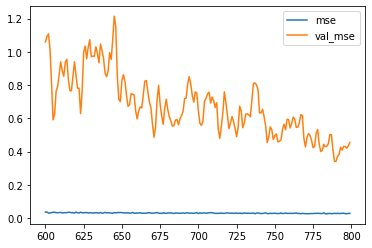

Prediction = -2.6153557300567627
Last corr = -0.529359
pred_col_name iwm_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.6297573486963908  minutes
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping


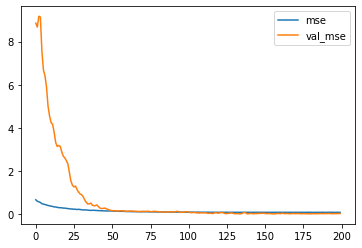

pred_col_name spy_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.621909745534261  minutes


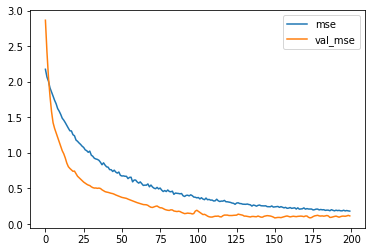

pred_col_name vfh_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18389507134755453  minutes
Restoring model weights from the end of the best epoch.
E

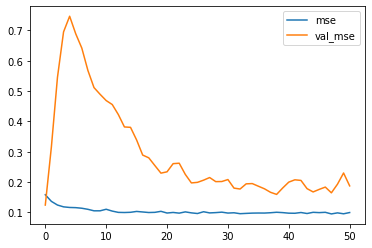

pred_col_name inn_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18017738262812297  minutes


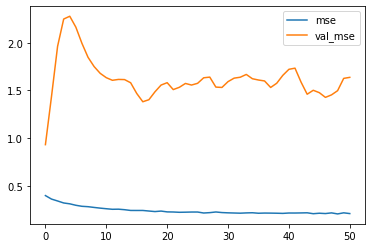

pred_col_name iwm_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
0.2638293941815694  minutes


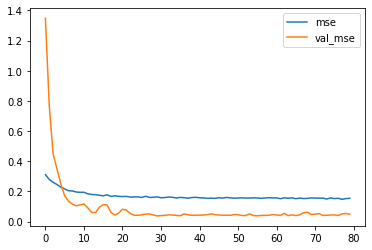

pred_col_name inn_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18657771348953248  minutes
Restoring model weights from the end of the best epoch.
E

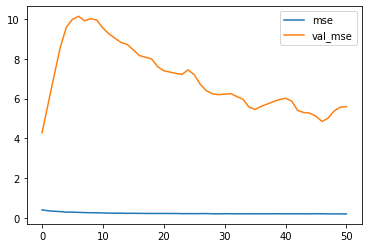

pred_col_name dia_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
0.5284308036168416  minutes


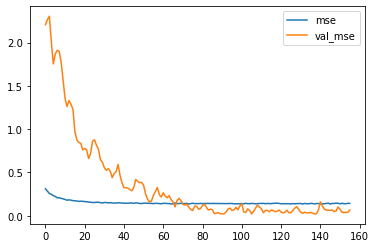

pred_col_name vgk_dia_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
0.34433859984079995  minutes
Restoring model weights from the end of the best epoch.
E

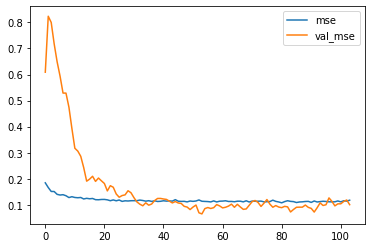

pred_col_name ibuy_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
0.19024773438771567  minutes
Restoring model weights from the end of the best epoch.


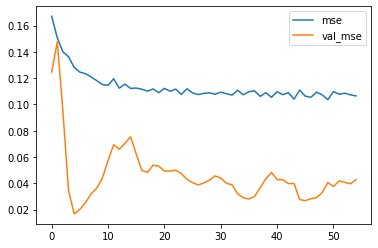

pred_col_name spy_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
0.2438567002614339  minutes
Restoring model weights from the end of the best epoch.
Ep

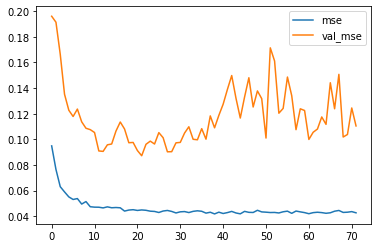

pred_col_name xrt_dia_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18140695095062256  minutes


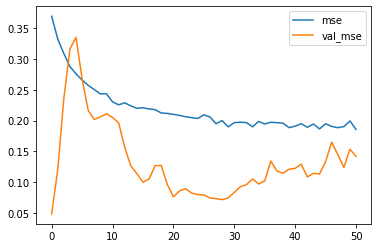

pred_col_name vgk_inn_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
0.401608935991923  minutes
Restoring model weights from the end of the best epoch.
Epo

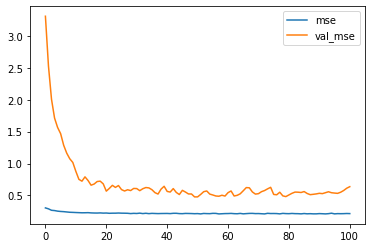

pred_col_name vgk_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
0.5790224154790242  minutes


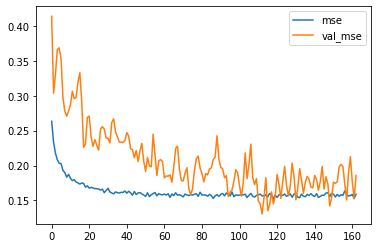

pred_col_name vfh_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
0.2221716324488322  minutes
Restoring model weights from the end of the best epoch.
Ep

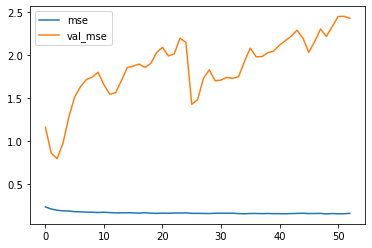

pred_col_name vgk_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
0.20881776412328085  minutes
Restoring model weights from the end of the best epoch.
E

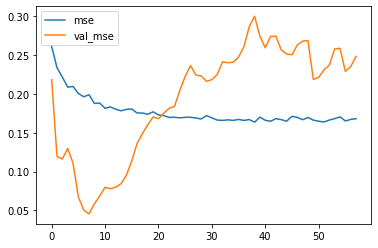

pred_col_name uso_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
0.22095433473587037  minutes
Restoring model weights from the end of the best epoch.
E

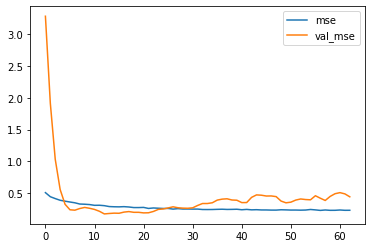

pred_col_name vgk_xrt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.6224370837211609  minutes
Restoring model weights from the end of the best epoch.
Epoch 00145: early stopping


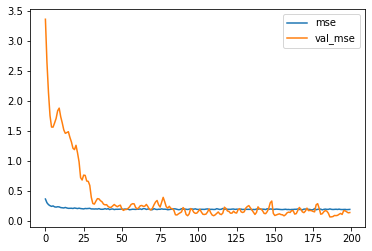

pred_col_name uso_pbj_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
0.21215259631474812  minutes


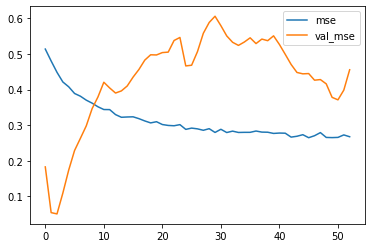

pred_col_name uso_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
0.23816920121510823  minutes
Restoring model weights from the end of the best epoch.


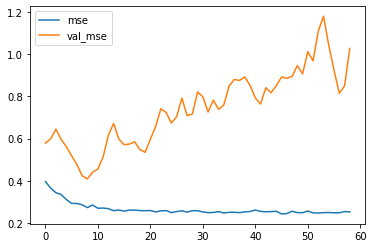

pred_col_name dia_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
0.40621163447697956  minutes


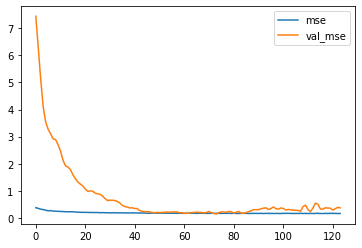

pred_col_name tlt_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
0.3838847478230794  minutes


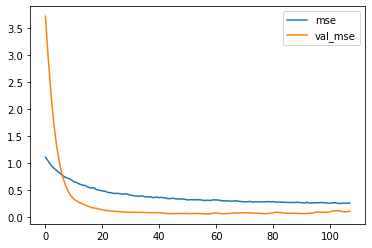

pred_col_name tlt_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
0.38933101495107014  minutes
Restoring model weights from the end of the best epoch.
E

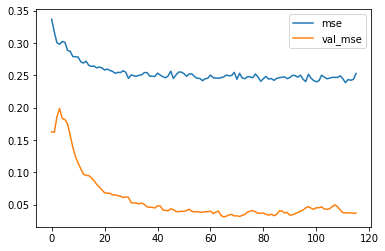

pred_col_name vgk_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
0.5109399318695068  minutes


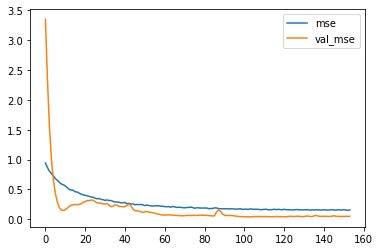

pred_col_name inn_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.19712326924006143  minutes
Restoring model weights from the end of the best epoch.
E

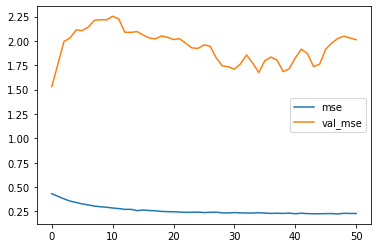

----------
Stock pairing = uso_inn
Pct finished = 0.20833333333333334
pred_col_name uso_inn_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18755353689193

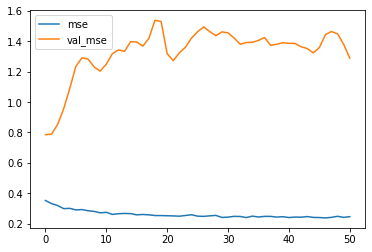

Prediction = 0.36984023451805115
Last corr = 0.523485
pred_col_name bjk_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00146: early stopping
0.4585545619328817  minutes
Resto

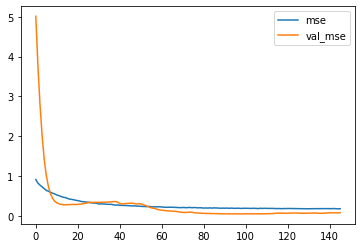

pred_col_name iwm_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.6159708778063456  minutes


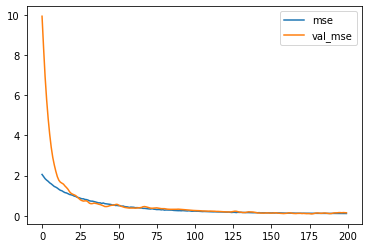

pred_col_name dia_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
0.36169201532999673  minutes
Restoring model weights from the end of the best epoch.
E

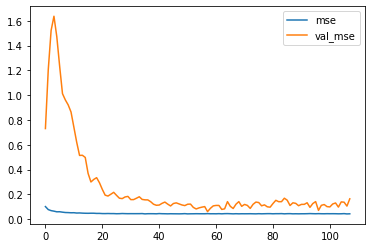

pred_col_name vfh_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
0.21934181451797485  minutes
Restoring model weights from the end of the best epoch.
E

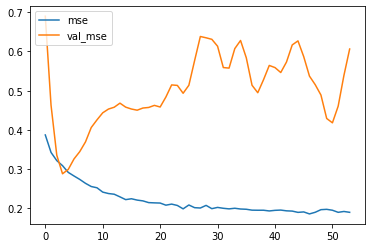

pred_col_name inn_xrt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18986726601918538  minutes


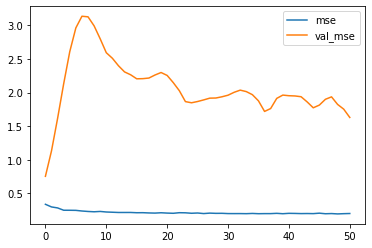

pred_col_name inn_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
0.18780529896418255  minutes
Restoring model weights from the end of the best epoch.
E

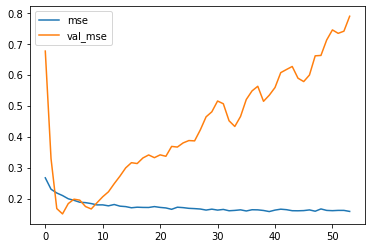

pred_col_name vti_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
0.4723496119181315  minutes
Restoring model weights from the end of the best epoch.
Ep

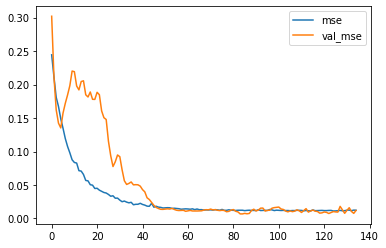

pred_col_name uso_dia_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
0.2275877356529236  minutes


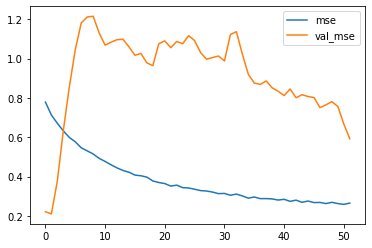

pred_col_name uso_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
0.4666363795598348  minutes
Restoring model weights from the end of the best epoch.
Ep

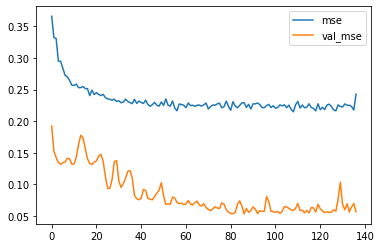

pred_col_name bjk_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
0.21364014943440754  minutes


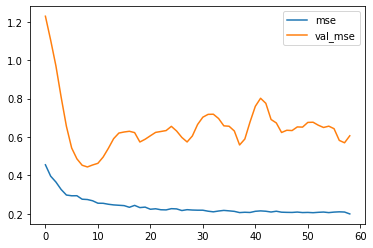

pred_col_name vfh_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
0.2247728188832601  minutes


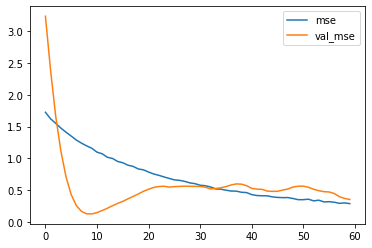

pred_col_name vgk_pbj_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
0.21718013286590576  minutes


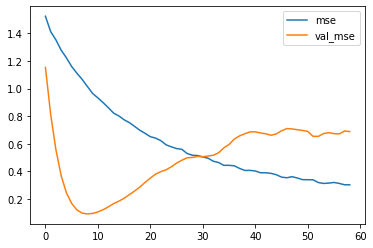

pred_col_name xrt_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
0.21329973538716634  minutes
Restoring model weights from the end of the best epoch.
E

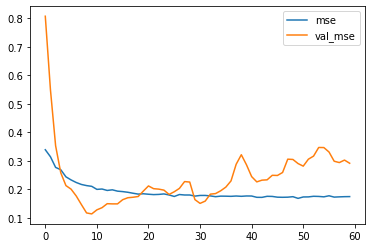

pred_col_name uso_tlt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
0.23252319892247517  minutes


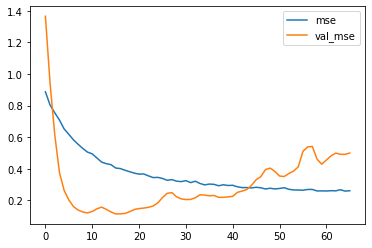

pred_col_name xrt_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
0.3700011690457662  minutes


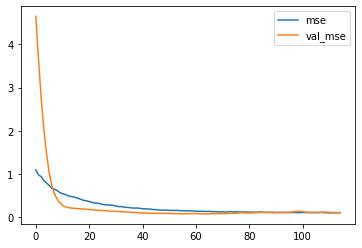

pred_col_name uso_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.6073975642522176  minutes
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping


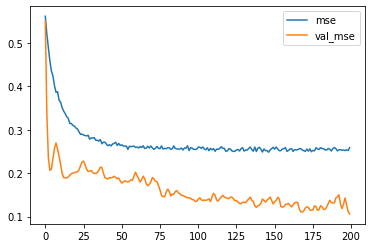

pred_col_name uso_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
0.30587728023529054  minutes
Restoring model weights from the end of the best epoch.
Ep

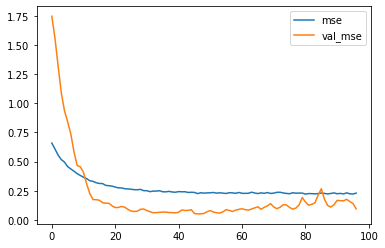

pred_col_name sh_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
0.36503641605377196  minutes
Restoring model weights from the end of the best epoch.
Ep

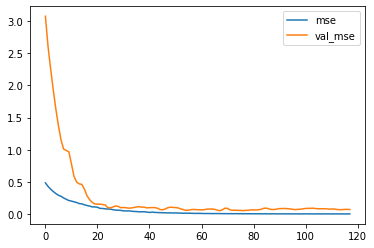

pred_col_name dia_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
0.23604016701380412  minutes


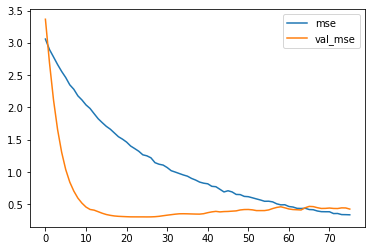

pred_col_name xrt_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
0.27787843147913616  minutes
Restoring model weights from the end of the best epoch.
E

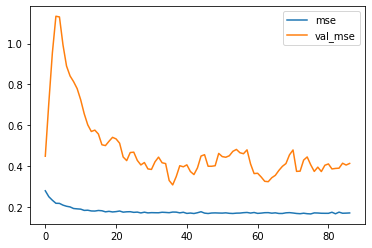

pred_col_name tlt_xrt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
0.21001630226771037  minutes


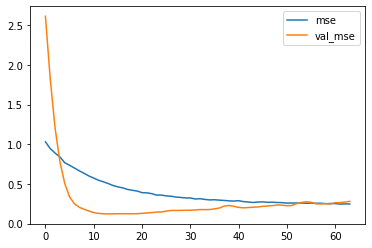

pred_col_name dia_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
0.28122806549072266  minutes


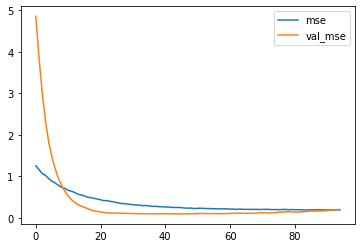

pred_col_name bjk_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
0.46591583093007405  minutes
Restoring model weights from the end of the best epoch.
E

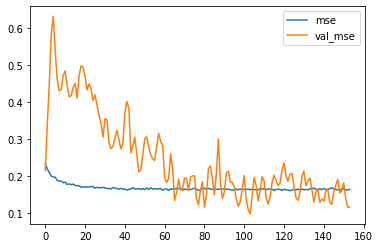

pred_col_name inn_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00187: early stopping
0.5298235893249512  minutes


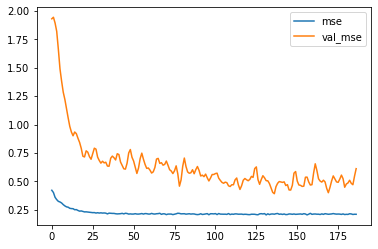

----------
Stock pairing = vti_ibuy
Pct finished = 0.4166666666666667
pred_col_name vti_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
0.2025626977284

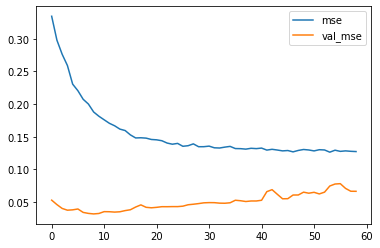

Prediction = 0.48856329917907715
Last corr = 0.866939
pred_col_name xrt_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
0.21879303455352783  minutes
Re

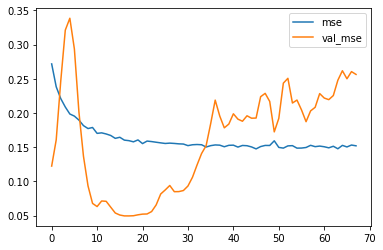

pred_col_name bjk_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
0.365969983736674  minutes


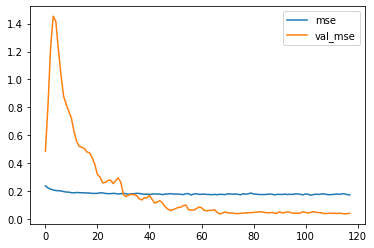

pred_col_name xrt_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
0.32495304743448894  minutes


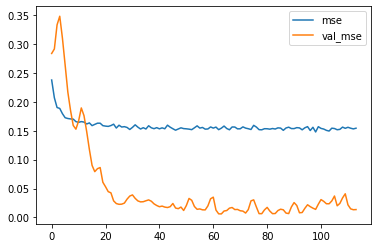

pred_col_name iwm_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
0.269809365272522  minutes
Restoring model weights from the end of the best epoch.
Ep

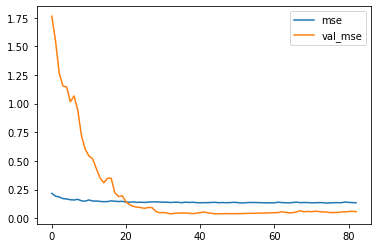

pred_col_name tlt_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
0.2255542516708374  minutes
Restoring model weights from the end of the best epoch.
E

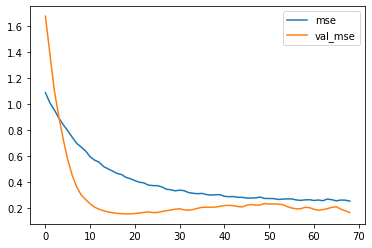

pred_col_name vti_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
0.23816338380177815  minutes


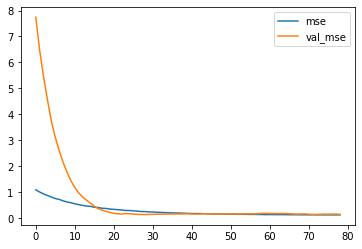

pred_col_name dia_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.1766828497250875  minutes
Restoring model weights from the end of the best epoch.
Ep

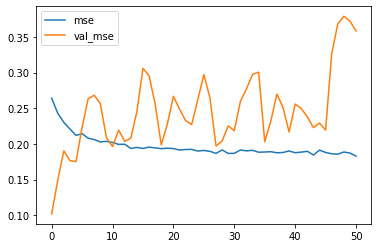

pred_col_name sh_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
0.3664010485013326  minutes
Restoring model weights from the end of the best epoch.
Ep

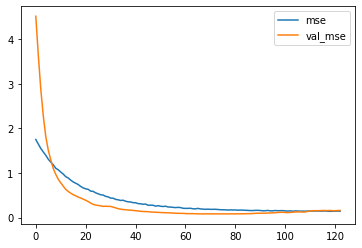

pred_col_name vgk_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
0.2048663338025411  minutes


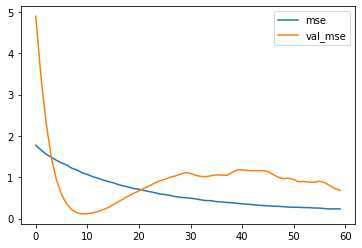

pred_col_name pbj_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.16652291615804035  minutes
Restoring model weights from the end of the best epoch.
E

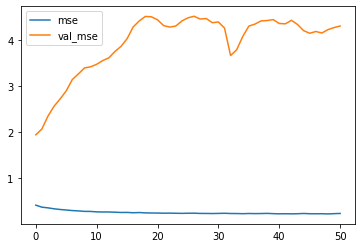

pred_col_name vgk_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
0.23158538738886517  minutes


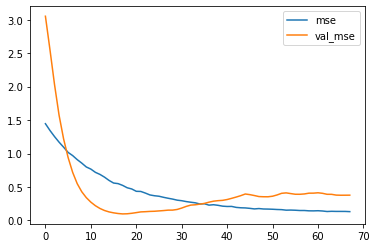

pred_col_name tlt_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
0.2422520359357198  minutes


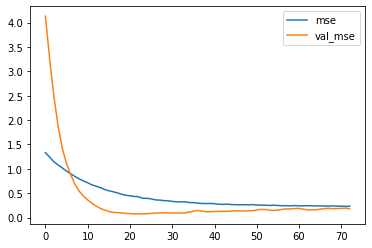

pred_col_name pbj_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
0.22989173332850138  minutes
Restoring model weights from the end of the best epoch.


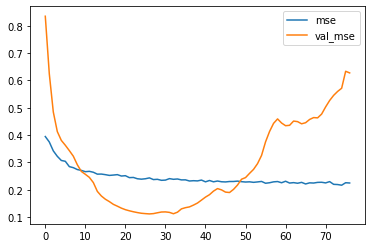

pred_col_name inn_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
0.1873326341311137  minutes


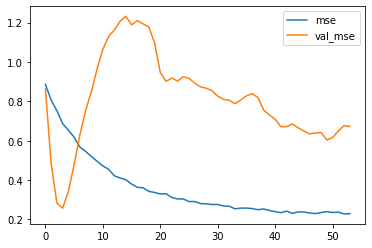

pred_col_name uso_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
0.28743271430333456  minutes


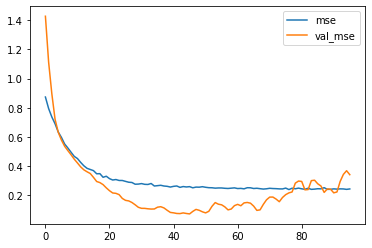

pred_col_name xrt_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00147: early stopping
0.4471638838450114  minutes
Restoring model weights from the end of the best epoch.
Epo

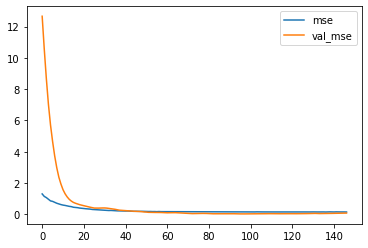

pred_col_name xrt_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
0.47488243579864503  minutes


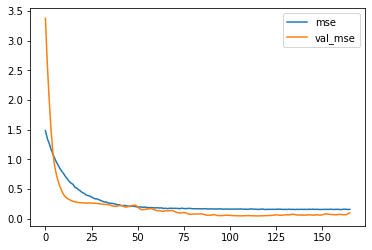

pred_col_name tlt_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
0.2527792970339457  minutes
Restoring model weights from the end of the best epoch.
Ep

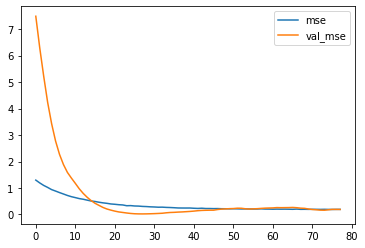

pred_col_name sh_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
0.34658856789271036  minutes
Restoring model weights from the end of the best epoch.
Ep

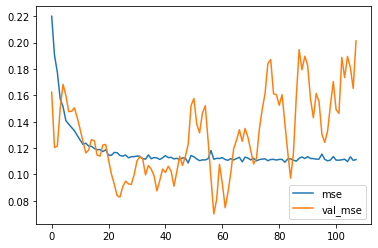

pred_col_name tlt_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
0.3565621336301168  minutes


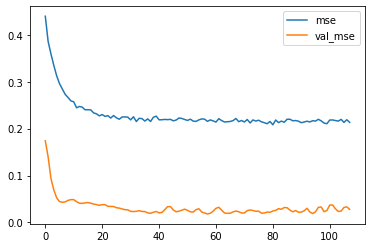

pred_col_name uso_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
0.23188045024871826  minutes
Restoring model weights from the end of the best epoch.
E

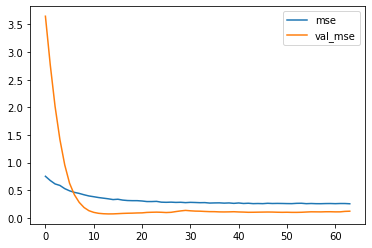

pred_col_name sh_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
0.34825462897618614  minutes


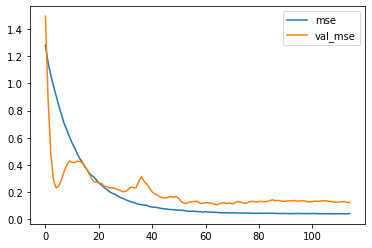

pred_col_name pbj_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
0.20527193148930867  minutes


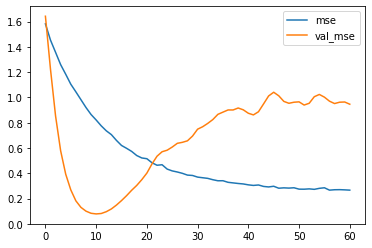

pred_col_name tlt_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
0.2920808990796407  minutes


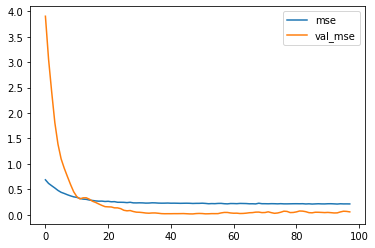

----------
Stock pairing = pej_qqq
Pct finished = 0.625
pred_col_name pej_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
0.4827084501584371  minutes
Re

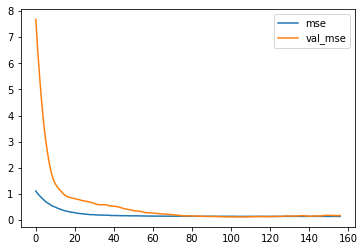

Prediction = 0.6907222867012024
Last corr = 0.730496
pred_col_name iwm_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
0.23525620301564534  minutes


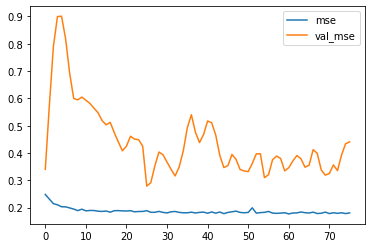

pred_col_name vgk_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00132: early stopping
0.4122650146484375  minutes
Restoring model weights from the end of the best epoch.
Ep

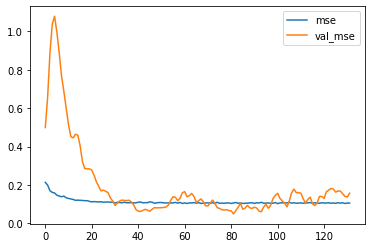

pred_col_name dia_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.576118016242981  minutes
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping


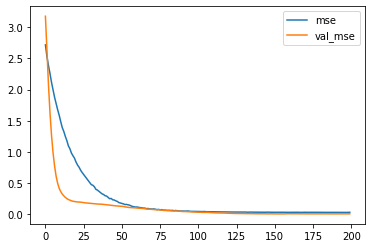

pred_col_name inn_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
0.19467081228892008  minutes
Restoring model weights from the end of the best epoch.


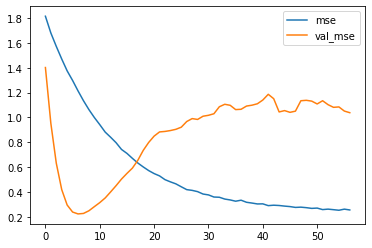

pred_col_name tlt_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.17105214595794677  minutes


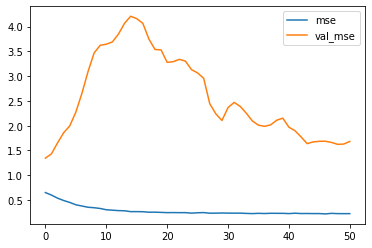

pred_col_name inn_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
0.19179076353708904  minutes
Restoring model weights from the end of the best epoch.
E

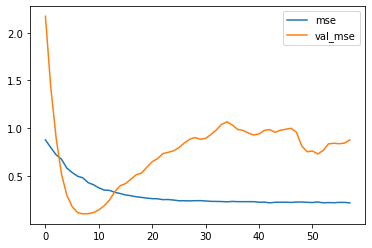

pred_col_name pbj_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
0.20439321597417195  minutes
Restoring model weights from the end of the best epoch.
E

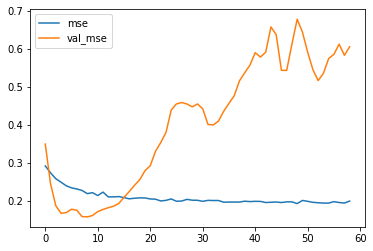

pred_col_name iwm_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
0.24112431605656942  minutes
Restoring model weights from the end of the best epoch.
E

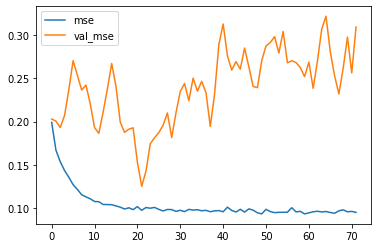

pred_col_name uso_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
0.1766236186027527  minutes


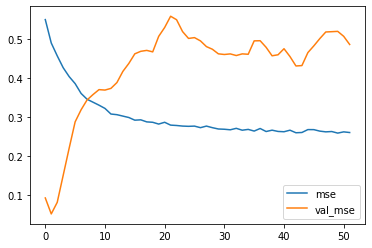

pred_col_name pbj_xrt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
0.42683560053507485  minutes
Restoring model weights from the end of the best epoch.
E

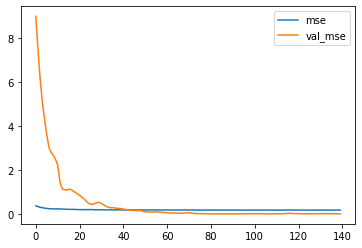

pred_col_name vti_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
0.3563597520192464  minutes
Restoring model weights from the end of the best epoch.
Ep

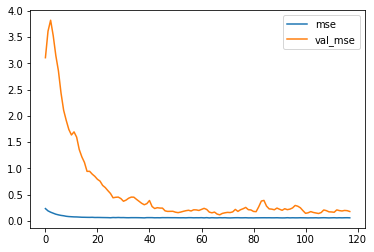

pred_col_name inn_tlt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
0.22191731532414755  minutes
Restoring model weights from the end of the best epoch.
E

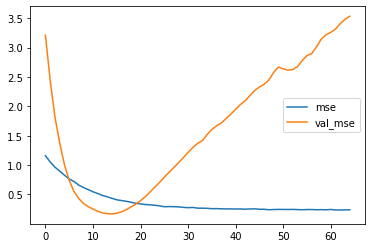

pred_col_name iwm_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
0.2649733463923136  minutes
Restoring model weights from the end of the best epoch.
Ep

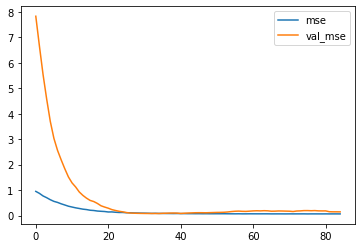

pred_col_name dia_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
0.23505751291910806  minutes


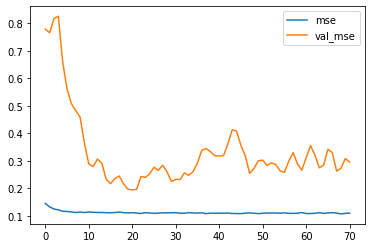

pred_col_name vfh_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
0.18547100226084393  minutes


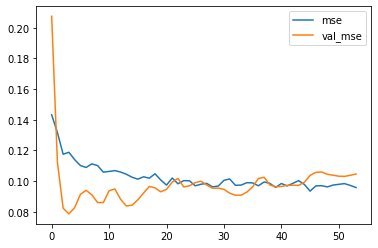

pred_col_name bjk_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.16958426237106322  minutes


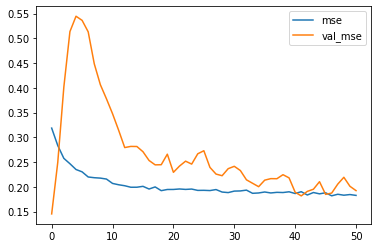

pred_col_name uso_xrt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
0.2264234185218811  minutes


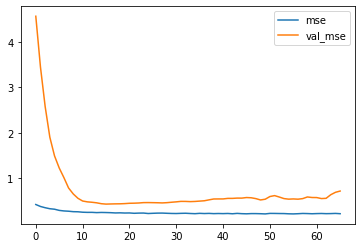

pred_col_name vgk_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00160: early stopping
0.46584148009618126  minutes


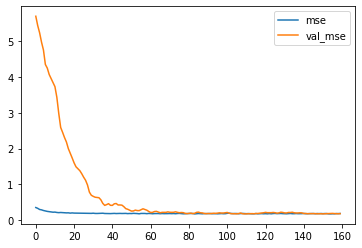

pred_col_name uso_iwm_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
0.19316910107930502  minutes
Restoring model weights from the end of the best epoch.
E

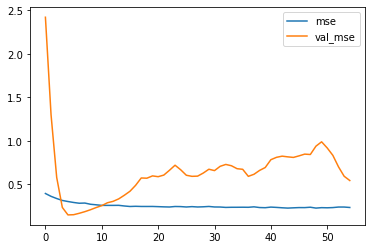

pred_col_name pbj_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00151: early stopping
0.4394623041152954  minutes


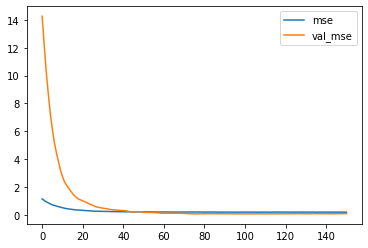

pred_col_name pbj_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
0.3567736864089966  minutes
Restoring model weights from the end of the best epoch.
Ep

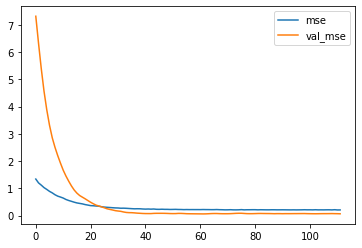

pred_col_name vgk_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00138: early stopping
0.4057518045107524  minutes
Restoring model weights from the end of the best epoch.
Ep

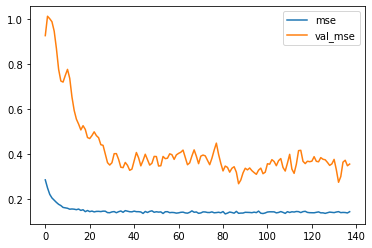

pred_col_name pbj_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
0.28901060422261554  minutes
Restoring model weights from the end of the best epoch.
E

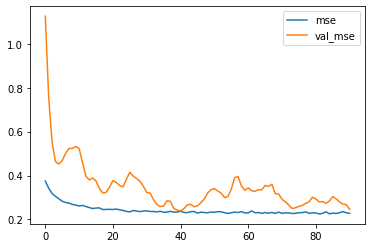

pred_col_name xrt_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
0.19059483210245767  minutes
Restoring model weights from the end of the best epoch.
E

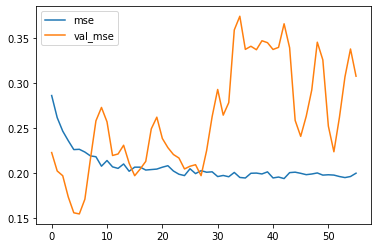

----------
Stock pairing = bjk_pej
Pct finished = 0.8333333333333334
pred_col_name bjk_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
0.269697217146555

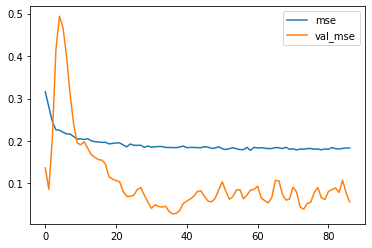

Prediction = 4.140266418457031
Last corr = 0.73246
pred_col_name inn_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping
0.5564237157503764  minutes
Restori

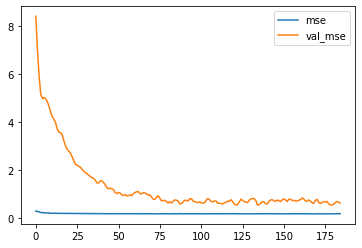

pred_col_name bjk_qqq_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
0.3590626319249471  minutes
Restoring model weights from the end of the best epoch.
Ep

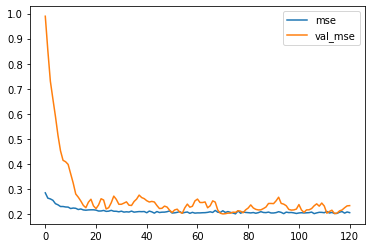

pred_col_name vfh_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
0.2904436349868774  minutes


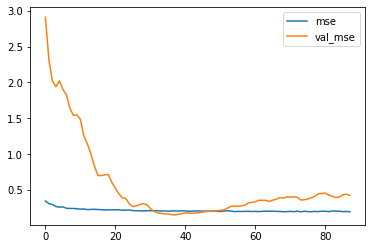

pred_col_name vti_sh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00141: early stopping
0.42757593393325805  minutes


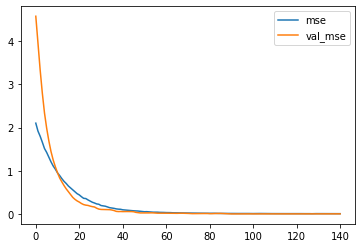

pred_col_name pej_ibuy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
0.22254568735758465  minutes


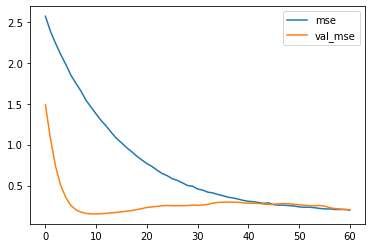

pred_col_name vgk_tlt_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
0.18797478278477986  minutes
Restoring model weights from the end of the best epoch.
E

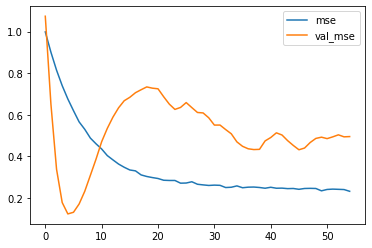

pred_col_name tlt_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
0.34869173367818196  minutes
Restoring model weights from the end of the best epoch.
E

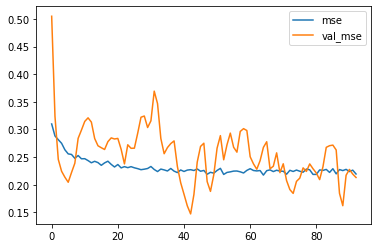

pred_col_name iwm_vfh_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
0.23516035079956055  minutes


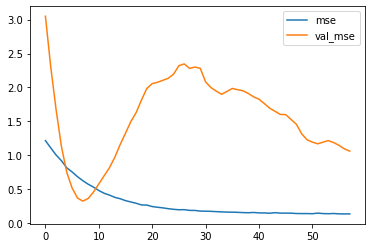

pred_col_name pbj_inn_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
0.2276576360066732  minutes
Restoring model weights from the end of the best epoch.
Ep

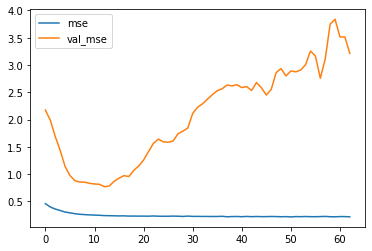

pred_col_name inn_dia_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
0.19099824825922648  minutes
Restoring model weights from the end of the best epoch.
E

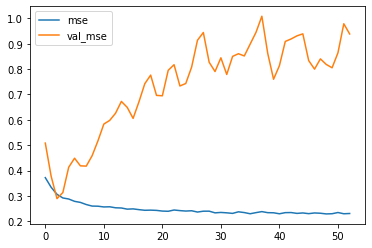

pred_col_name spy_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
0.1897183895111084  minutes
Restoring model weights from the end of the best epoch.
Ep

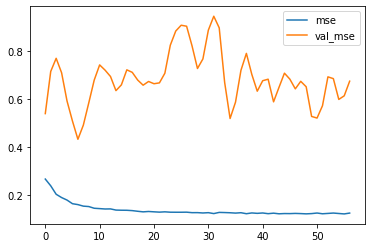

pred_col_name pbj_pej_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.18193278312683106  minutes
Restoring model weights from the end of the best epoch.
E

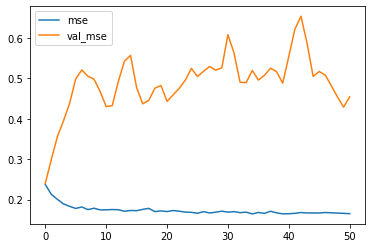

pred_col_name uso_vgk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
0.1828307310740153  minutes
Restoring model weights from the end of the best epoch.
Ep

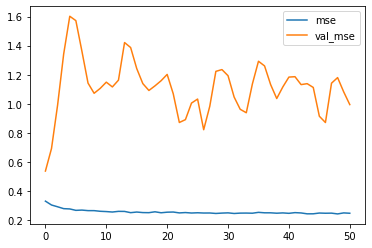

pred_col_name pbj_dia_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
0.5719238162040711  minutes
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping


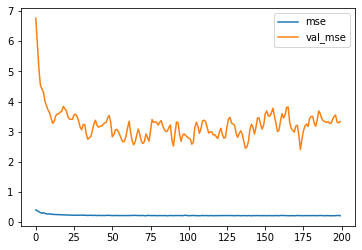

pred_col_name tlt_dia_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
0.303271476427714  minutes


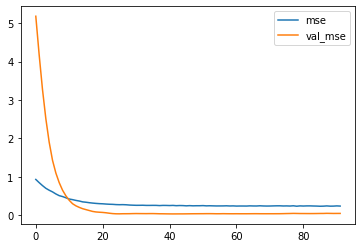

pred_col_name dia_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
0.20028711557388307  minutes


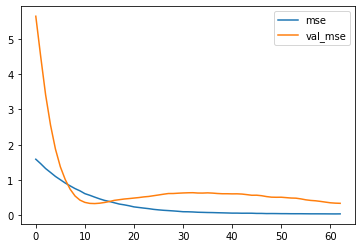

pred_col_name xrt_bjk_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
0.46291073560714724  minutes


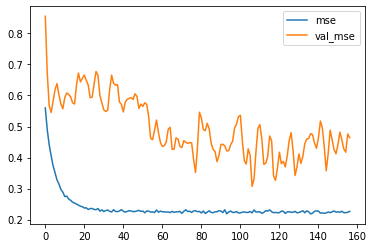

pred_col_name pbj_vti_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
0.24555521806081135  minutes
Restoring model weights from the end of the best epoch.
E

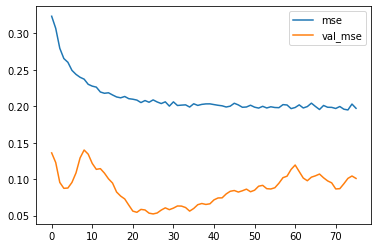

pred_col_name vgk_spy_close_corr_rolling_7_days
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 852
Total idx checked 882
Val idx start at 853
Val idx end at 882
X val shape (15, 14, 779)
n_sequences 881
Training idx start at 0
Pct finished = 0.11350737797956867
Pct finished = 0.22701475595913734
Pct finished = 0.340522133938706
Pct finished = 0.4540295119182747
Pct finished = 0.5675368898978433
Pct finished = 0.681044267877412
Pct finished = 0.7945516458569807
Pct finished = 0.9080590238365494
Training idx end at 882
Total idx checked 882
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
0.34810503721237185  minutes
Restoring model weights from the end of the best epoch.
E

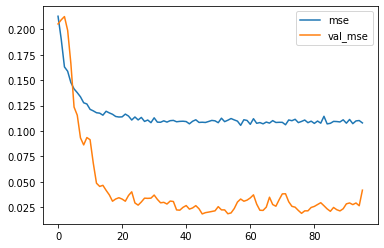

Predictions took 100.08018951416015 mins


In [184]:
# 6.5 minutes for 10 stocks
final_stock_df = final_stock_df.dropna()
# test 14 day period instead of 30
# no dice
# test smaller network smae LR
# no dice
# test since 2016 data
# no dice
# test smaller learning rate 
# no dice
# test smaller batch size
# nothing
# test batch size  


# so the solution was less validation data

# wal_cwbc is turns out needed less training data

# test a new model for each pair, 200 epochs per . 2 minutes per 200 epochs
# 300 pairs take 10 hours sequentially
# X,y, X_val, y_val, scalers, pca_scalers 
prediction_for_upcoming_week(final_stock_df, pairs_of_stocks, input_verbose=0)

In [185]:
training_data

NameError: name 'training_data' is not defined

In [ ]:
np.isnan(X_val).sum()

In [ ]:
np.isnan(new_X_test).sum()